In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
from collections import Counter


In [2]:
# Load dataset
df = pd.read_excel('../data/Dataset_2020-2024.xlsx')
df.head(10)


,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,01-01-2020,25,31.2,25.4,91,19.9,3.2,10,220,2,NW
1,02-01-2020,24.2,32,27.5,85,14.8,1,4,240,1,C
2,03-01-2020,25.1,32,27.5,86,2.1,3.5,8,250,2,C
3,04-01-2020,24.9,31.8,27.5,88,2.5,4,7,230,2,C
4,05-01-2020,25.2,29.7,26.3,91,6.5,4.5,4,240,2,C
5,06-01-2020,24.2,32.2,27.6,84,12.5,0.5,4,240,2,C
6,07-01-2020,25,29.6,26.8,89,23.8,6.3,4,290,1,C
7,08-01-2020,-,29.4,27.3,85,13.7,-,4,180,1,C
8,10-01-2020,24.8,31.4,26.7,85,24,2.5,4,210,1,C
9,11-01-2020,24,31.5,27.3,84,17.1,1.4,5,240,2,C


In [3]:
df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan)
df = df.infer_objects(copy=False)
pd.set_option('future.no_silent_downcasting', True)


C:\Users\HP\AppData\Local\Temp\ipykernel_4452\3301776776.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['8888', '9999', '-', 8888, 9999], np.nan)


In [4]:
# Mendefinisikan kolom-kolom yang seharusnya numerik
numeric_columns = ['TN', 'TX', 'TAVG', 'RH_AVG', 'RR', 'SS']
# Mengonversi kolom-kolom numerik yang mungkin bertipe object menjadi float
# 'errors="coerce"' mengubah nilai yang tidak bisa dikonversi menjadi NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n--- Informasi Setelah Penggantian NaN & Konversi Tipe ---")
df[numeric_columns].info()
print("\n--- 10 Baris Pertama Setelah Penggantian NaN & Konversi Tipe ---")
print(df.head(10))


--- Informasi Setelah Penggantian NaN & Konversi Tipe ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TN      1633 non-null   float64
 1   TX      1770 non-null   float64
 2   TAVG    1794 non-null   float64
 3   RH_AVG  1796 non-null   float64
 4   RR      1327 non-null   float64
 5   SS      1760 non-null   float64
dtypes: float64(6)
memory usage: 85.2 KB

--- 10 Baris Pertama Setelah Penggantian NaN & Konversi Tipe ---
      TANGGAL    TN    TX  TAVG  RH_AVG    RR   SS  FF_X  DDD_X  FF_AVG  \
0  01-01-2020  25.0  31.2  25.4    91.0  19.9  3.2    10    220       2   
1  02-01-2020  24.2  32.0  27.5    85.0  14.8  1.0     4    240       1   
2  03-01-2020  25.1  32.0  27.5    86.0   2.1  3.5     8    250       2   
3  04-01-2020  24.9  31.8  27.5    88.0   2.5  4.0     7    230       2   
4  05-01-2020  25.2  29.7  26.3    91.0   6.5  4.5     4 

In [5]:
# --- Pengurutan Data Berdasarkan Waktu ---
# Mengubah 'Tanggal' menjadi 'TANGGAL' sesuai dengan output df.info()
if 'TANGGAL' in df.columns:
    # Menentukan format tanggal secara eksplisit sebagai DD-MM-YYYY
    df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')
    df = df.sort_values(by='TANGGAL').reset_index(drop=True)
    print("\nData berhasil diurutkan berdasarkan kolom 'TANGGAL'.")
else:
    print("\nKolom 'TANGGAL' tidak ditemukan. Mengasumsikan data sudah terurut waktu.")

print("\n--- Informasi Setelah Pengurutan Berdasarkan Waktu ---")
print(df.head())


Data berhasil diurutkan berdasarkan kolom 'TANGGAL'.

--- Informasi Setelah Pengurutan Berdasarkan Waktu ---
     TANGGAL    TN    TX  TAVG  RH_AVG    RR   SS  FF_X  DDD_X  FF_AVG DDD_CAR
0 2020-01-01  25.0  31.2  25.4    91.0  19.9  3.2    10    220       2      NW
1 2020-01-02  24.2  32.0  27.5    85.0  14.8  1.0     4    240       1      C 
2 2020-01-03  25.1  32.0  27.5    86.0   2.1  3.5     8    250       2      C 
3 2020-01-04  24.9  31.8  27.5    88.0   2.5  4.0     7    230       2      C 
4 2020-01-05  25.2  29.7  26.3    91.0   6.5  4.5     4    240       2      C 


In [6]:
print(df.isna().sum())

TANGGAL      0
TN         181
TX          44
TAVG        20
RH_AVG      18
RR         487
SS          54
FF_X         0
DDD_X        0
FF_AVG       0
DDD_CAR      0
dtype: int64


In [7]:
#imputasi pake median
columns_to_impute = df.select_dtypes(include=np.number).columns.tolist()
if 'TANGGAL' in columns_to_impute:
    columns_to_impute.remove('TANGGAL')
imputer = SimpleImputer(strategy='median')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

print("\n--- Informasi Setelah Imputasi Median ---")
print("\n--- Jumlah NaN Setelah Imputasi Awal Semua Kolom Numerik ---")
print(df.isna().sum())
print (df.head(10))


--- Informasi Setelah Imputasi Median ---

--- Jumlah NaN Setelah Imputasi Awal Semua Kolom Numerik ---
TANGGAL    0
TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64
     TANGGAL    TN    TX  TAVG  RH_AVG    RR    SS  FF_X  DDD_X  FF_AVG  \
0 2020-01-01  25.0  31.2  25.4    91.0  19.9  3.20  10.0  220.0     2.0   
1 2020-01-02  24.2  32.0  27.5    85.0  14.8  1.00   4.0  240.0     1.0   
2 2020-01-03  25.1  32.0  27.5    86.0   2.1  3.50   8.0  250.0     2.0   
3 2020-01-04  24.9  31.8  27.5    88.0   2.5  4.00   7.0  230.0     2.0   
4 2020-01-05  25.2  29.7  26.3    91.0   6.5  4.50   4.0  240.0     2.0   
5 2020-01-06  24.2  32.2  27.6    84.0  12.5  0.50   4.0  240.0     2.0   
6 2020-01-07  25.0  29.6  26.8    89.0  23.8  6.30   4.0  290.0     1.0   
7 2020-01-08  25.0  29.4  27.3    85.0  13.7  6.85   4.0  180.0     1.0   
8 2020-01-10  24.8  31.4  26.7    85.0  24.0  2.50   4.0  210.0 

In [8]:
# Feature lag dan rolling
df['RR_lag1'] = df['RR'].shift(1)
df['TAVG_lag1'] = df['TAVG'].shift(1)
df['RH_AVG_lag1'] = df['RH_AVG'].shift(1)
df['SS_lag1'] = df['SS'].shift(1)
df['TX_lag1'] = df['TX'].shift(1)
df['TN_lag1'] = df['TN'].shift(1)
df['RR_rolling_mean_3d_lag1'] = df['RR'].rolling(window=3, min_periods=1).mean().shift(1)

df.dropna(inplace=True)

print("\n--- 10 Baris Pertama Setelah Pembuatan Fitur Lag ---")
print(df.head(10))
print("\n--- Jumlah NaN Setelah Pembuatan Fitur Lag ---")
print(df.isna().sum())



--- 10 Baris Pertama Setelah Pembuatan Fitur Lag ---
      TANGGAL    TN    TX  TAVG  RH_AVG    RR    SS  FF_X  DDD_X  FF_AVG  \
1  2020-01-02  24.2  32.0  27.5    85.0  14.8  1.00   4.0  240.0     1.0   
2  2020-01-03  25.1  32.0  27.5    86.0   2.1  3.50   8.0  250.0     2.0   
3  2020-01-04  24.9  31.8  27.5    88.0   2.5  4.00   7.0  230.0     2.0   
4  2020-01-05  25.2  29.7  26.3    91.0   6.5  4.50   4.0  240.0     2.0   
5  2020-01-06  24.2  32.2  27.6    84.0  12.5  0.50   4.0  240.0     2.0   
6  2020-01-07  25.0  29.6  26.8    89.0  23.8  6.30   4.0  290.0     1.0   
7  2020-01-08  25.0  29.4  27.3    85.0  13.7  6.85   4.0  180.0     1.0   
8  2020-01-10  24.8  31.4  26.7    85.0  24.0  2.50   4.0  210.0     1.0   
9  2020-01-11  24.0  31.5  27.3    84.0  17.1  1.40   5.0  240.0     2.0   
10 2020-01-12  24.2  32.2  27.9    82.0   3.0  1.00   4.0  250.0     2.0   

   DDD_CAR  RR_lag1  TAVG_lag1  RH_AVG_lag1  SS_lag1  TX_lag1  TN_lag1  \
1       C      19.9       25.4     

In [9]:
# Kategorisasi RR
def rr_categorization(rr):
    if rr == 0:
        return 'No Rain'
    elif 0 < rr <= 20:
        return 'Hujan Ringan'
    elif 20 < rr <= 50:
        return 'Hujan Sedang'
    elif 50 < rr <= 100:
        return 'Hujan Lebat'
    else:
        return 'Hujan Sangat Lebat'

df['RR_KAT'] = df['RR'].apply(rr_categorization)


print("\n--- Distribusi Kategori Curah Hujan (RR_KAT) ---")
print(df['RR_KAT'].value_counts())


--- Distribusi Kategori Curah Hujan (RR_KAT) ---
RR_KAT
Hujan Ringan          1245
No Rain                300
Hujan Sedang           177
Hujan Lebat             72
Hujan Sangat Lebat      19
Name: count, dtype: int64


In [10]:
le = LabelEncoder()
df['RR_KAT_ENC'] = le.fit_transform(df['RR_KAT'])

# Membuat mapping dari label asli ke angka untuk interpretasi hasil
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\n--- Label Encoding Mapping ---")
for original, encoded in label_mapping.items():
    print(f"{original} → {encoded}")


--- Label Encoding Mapping ---
Hujan Lebat → 0
Hujan Ringan → 1
Hujan Sangat Lebat → 2
Hujan Sedang → 3
No Rain → 4


In [11]:
# Fitur dan target
feature_columns = [
    'TN', 'TX', 'TAVG', 'RH_AVG', 'SS',
    'RR_lag1', 'TAVG_lag1', 'RH_AVG_lag1', 'SS_lag1', 'TX_lag1', 'TN_lag1',
    'RR_rolling_mean_3d_lag1'
]

X = df[feature_columns]
y = df['RR_KAT_ENC']

print("\n--- Head X (Fitur) ---")
print(X.head())
print("\n--- Head y (Target) ---")
print(y.head())


--- Head X (Fitur) ---
     TN    TX  TAVG  RH_AVG   SS  RR_lag1  TAVG_lag1  RH_AVG_lag1  SS_lag1  \
1  24.2  32.0  27.5    85.0  1.0     19.9       25.4         91.0      3.2   
2  25.1  32.0  27.5    86.0  3.5     14.8       27.5         85.0      1.0   
3  24.9  31.8  27.5    88.0  4.0      2.1       27.5         86.0      3.5   
4  25.2  29.7  26.3    91.0  4.5      2.5       27.5         88.0      4.0   
5  24.2  32.2  27.6    84.0  0.5      6.5       26.3         91.0      4.5   

   TX_lag1  TN_lag1  RR_rolling_mean_3d_lag1  
1     31.2     25.0                19.900000  
2     32.0     24.2                17.350000  
3     32.0     25.1                12.266667  
4     31.8     24.9                 6.466667  
5     29.7     25.2                 3.700000  

--- Head y (Target) ---
1    1
2    1
3    1
4    1
5    1
Name: RR_KAT_ENC, dtype: int64


In [12]:
#Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Mengonversi kembali ke DataFrame untuk memudahkan analisis lebih lanjut
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
print("\n--- Head X Setelah Standardisasi ---")
print(X_scaled_df.head())



--- Head X Setelah Standardisasi ---
         TN        TX      TAVG    RH_AVG        SS   RR_lag1  TAVG_lag1  \
1 -0.808190  0.802128  0.076228  0.486611 -1.759318  0.465337  -2.021868   
2  0.177477  0.802128  0.076228  0.771843 -0.906262  0.222757   0.077300   
3 -0.041560  0.656199  0.076228  1.342309 -0.735651 -0.381316   0.077300   
4  0.286995 -0.876058 -1.124650  2.198007 -0.565040 -0.362290   0.077300   
5 -0.808190  0.948057  0.176301  0.201378 -1.929929 -0.172031  -1.122225   

   RH_AVG_lag1   SS_lag1   TX_lag1   TN_lag1  RR_rolling_mean_3d_lag1  
1     2.193892 -1.007905  0.218769  0.067660                 0.734168  
2     0.484353 -1.758391  0.802582 -0.808543                 0.542796  
3     0.769277 -0.905566  0.802582  0.177186                 0.161302  
4     1.339123 -0.735001  0.656629 -0.041865                -0.273976  
5     2.193892 -0.564436 -0.875880  0.286711                -0.481609  



--- Distribusi Target Sebelum SMOTE ---
Counter({1: 1245, 4: 300, 3: 177, 0: 72, 2: 19})


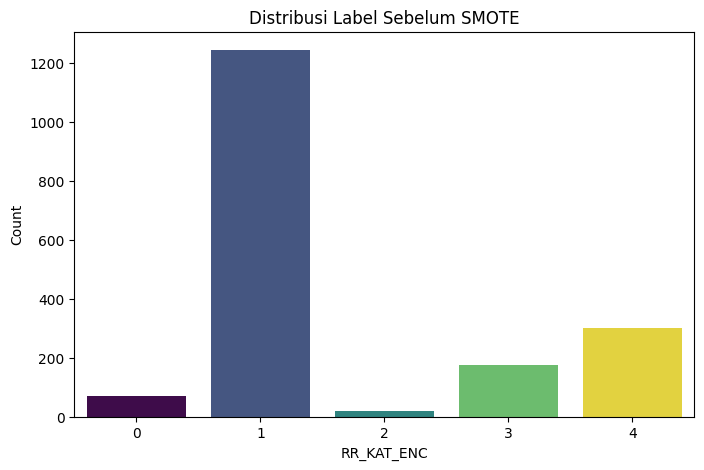

In [13]:
print("\n--- Distribusi Target Sebelum SMOTE ---")
print(Counter(y))
# Distribusi Target Sebelum SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y, hue=y, palette='viridis', legend=False)
plt.title("Distribusi Label Sebelum SMOTE")
plt.xlabel("RR_KAT_ENC")
plt.ylabel("Count")
plt.show()

In [14]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)



--- Distribusi Target Setelah SMOTE ---
Counter({1: 1245, 3: 1245, 4: 1245, 0: 1245, 2: 1245})


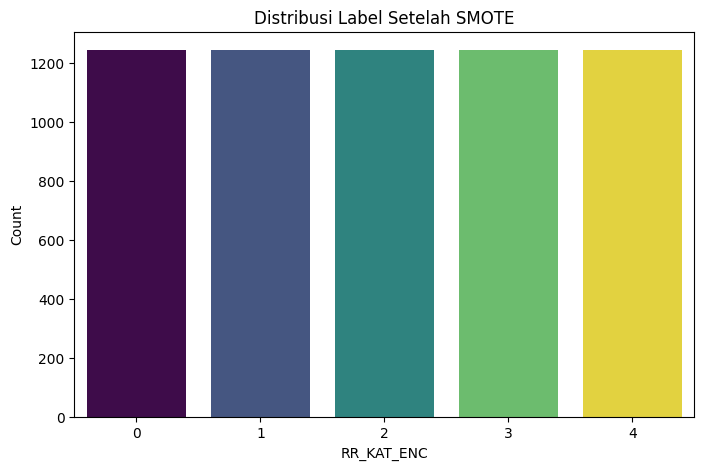

In [15]:
print("\n--- Distribusi Target Setelah SMOTE ---")
print(Counter(y_bal))

plt.figure(figsize=(8, 5))
sns.countplot(x=y_bal, hue=y_bal, palette='viridis', legend=False)
plt.title("Distribusi Label Setelah SMOTE")
plt.xlabel("RR_KAT_ENC")
plt.ylabel("Count")
plt.show()



In [16]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)


print("\n--- Distribusi Data Setelah Split ---")
print("Distribusi Train:")
print(Counter(y_train))
print("\nDistribusi Test:")
print(Counter(y_test))

print("\nPreprocessing Lengkap! X_train, X_test, y_train, y_test siap untuk pelatihan model.")



--- Distribusi Data Setelah Split ---
Distribusi Train:
Counter({4: 996, 3: 996, 2: 996, 1: 996, 0: 996})

Distribusi Test:
Counter({4: 249, 3: 249, 1: 249, 2: 249, 0: 249})

Preprocessing Lengkap! X_train, X_test, y_train, y_test siap untuk pelatihan model.


In [17]:
# Inisiasi Model
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Random Forest': RandomForestClassifier(random_state=42),
}

In [18]:
# Cross Validation
print("=== Cross Validation Metrics (Precision, Recall, F1) ===\n")


for name, model in models.items():
    y_pred_cv = cross_val_predict(model, X_bal, y_bal, cv=5)
    print(f"\n--- {name} ---")
    print(classification_report(y_bal, y_pred_cv, target_names=le.classes_))
    acc = accuracy_score(y_bal, y_pred_cv)
    print(f"Akurasi (CV): {acc:.4f}")

=== Cross Validation Metrics (Precision, Recall, F1) ===


--- Naive Bayes ---
                    precision    recall  f1-score   support

       Hujan Lebat       0.36      0.28      0.31      1245
      Hujan Ringan       0.51      0.11      0.19      1245
Hujan Sangat Lebat       0.54      0.65      0.59      1245
      Hujan Sedang       0.44      0.47      0.45      1245
           No Rain       0.46      0.80      0.59      1245

          accuracy                           0.46      6225
         macro avg       0.46      0.46      0.43      6225
      weighted avg       0.46      0.46      0.43      6225

Akurasi (CV): 0.4620

--- KNN ---
                    precision    recall  f1-score   support

       Hujan Lebat       0.87      0.99      0.92      1245
      Hujan Ringan       0.84      0.25      0.38      1245
Hujan Sangat Lebat       0.93      1.00      0.97      1245
      Hujan Sedang       0.81      0.95      0.88      1245
           No Rain       0.71      0.94    


=== Confusion Matrices (Cross Validation) ===



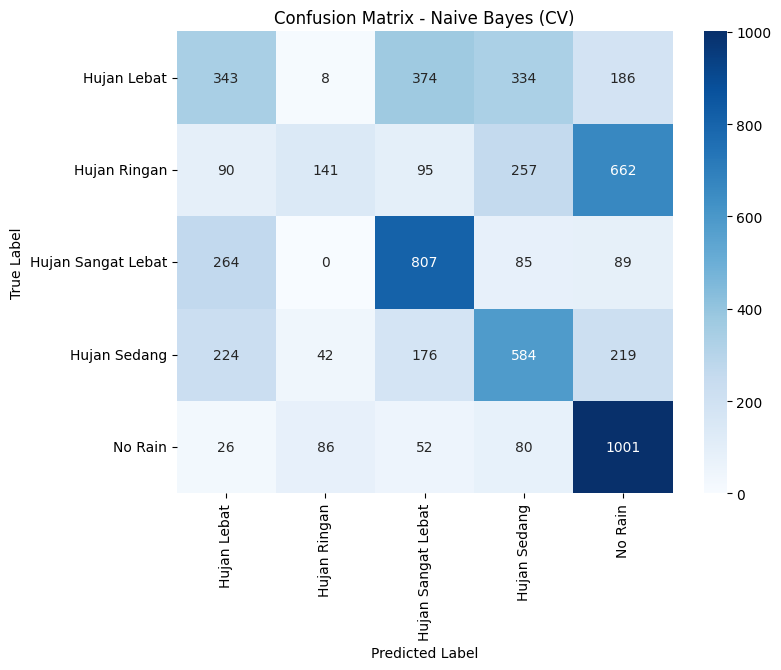

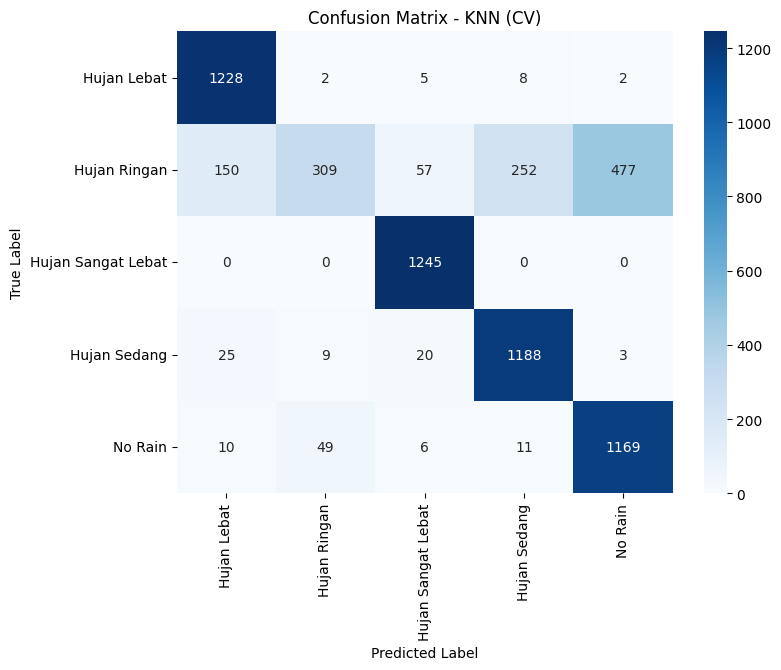

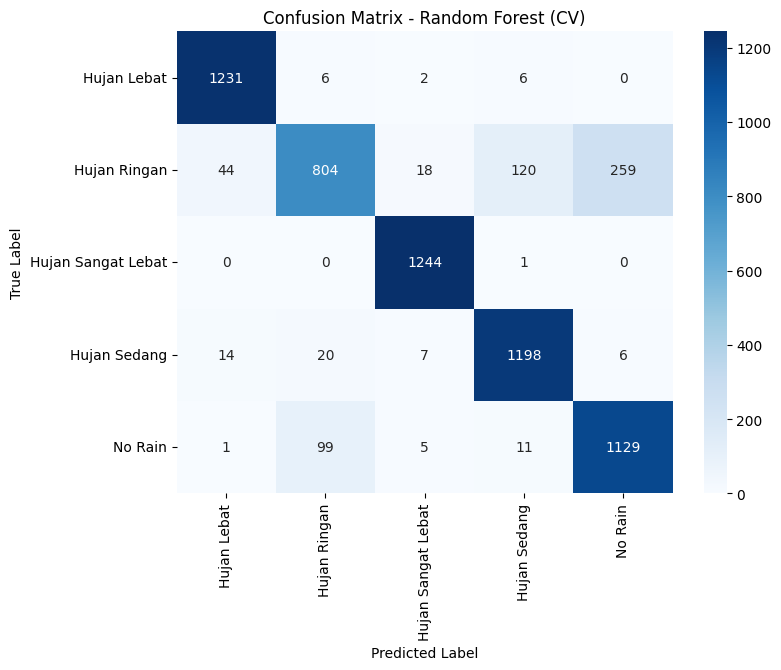

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Buat confusion matrix untuk setiap model menggunakan hasil cross-validation
print("\n=== Confusion Matrices (Cross Validation) ===\n")

for name, model in models.items():
    y_pred_cv = cross_val_predict(model, X_bal, y_bal, cv=5)
    plot_confusion_matrix(y_bal, y_pred_cv, classes=le.classes_, title=f'Confusion Matrix - {name} (CV)')

In [20]:
# === 10. Stacking Classifier ===
stacking_clf = StackingClassifier(
    estimators=[
        ('nb', models['Naive Bayes']),
        ('knn', models['KNN']),
        ('rf', models['Random Forest'])
    ],
    final_estimator=RandomForestClassifier(random_state=42)
)
y_pred_stacking = cross_val_predict(stacking_clf, X_bal, y_bal, cv=5)
print("\n--- Stacking Classifier ---")
print(classification_report(y_bal, y_pred_stacking, target_names=le.classes_))
print(f"Akurasi (CV): {accuracy_score(y_bal, y_pred_stacking):.4f}")



--- Stacking Classifier ---
                    precision    recall  f1-score   support

       Hujan Lebat       0.99      0.98      0.98      1245
      Hujan Ringan       0.82      0.83      0.83      1245
Hujan Sangat Lebat       0.99      1.00      0.99      1245
      Hujan Sedang       0.96      0.96      0.96      1245
           No Rain       0.88      0.87      0.87      1245

          accuracy                           0.93      6225
         macro avg       0.93      0.93      0.93      6225
      weighted avg       0.93      0.93      0.93      6225

Akurasi (CV): 0.9267


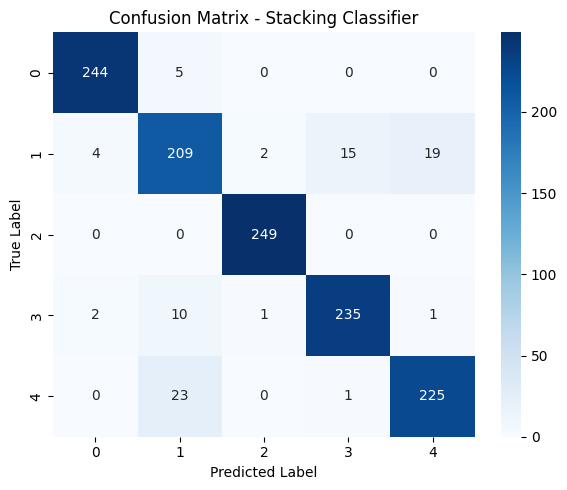

In [21]:
# Train the stacking classifier on the training data
stacking_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = stacking_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
class_names = np.unique(y_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Stacking Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_4452\648141549.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_metrics, x='Model', y='Accuracy', palette='viridis')


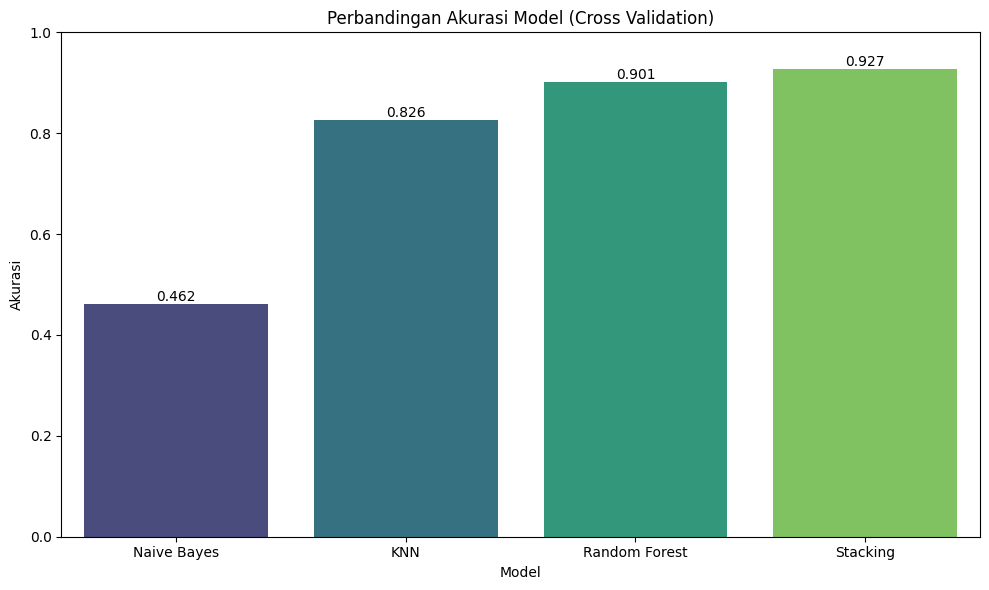

In [22]:
# Filter the DataFrame to get only the overall accuracy for each model
# Buat DataFrame metrik evaluasi manual
def compute_metrics(model_name, y_true, y_pred):
    return {
        'Model': model_name,
        'Class': 'Overall',
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1-Score': f1_score(y_true, y_pred, average='macro')
    }

metrics_data = []

# Hitung metrik untuk tiap model
for name, model in models.items():
    y_pred = cross_val_predict(model, X_bal, y_bal, cv=5)
    metrics_data.append(compute_metrics(name, y_bal, y_pred))

# Stacking
metrics_data.append(compute_metrics('Stacking', y_bal, y_pred_stacking))

df_metrics = pd.DataFrame(metrics_data)

# Plot Accuracy
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_metrics, x='Model', y='Accuracy', palette='viridis')
plt.title('Perbandingan Akurasi Model (Cross Validation)')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()


In [23]:
# # Save all trained models (Naive Bayes, KNN, Random Forest, Stacking)
# joblib.dump(models['Naive Bayes'], '../model/naive_bayes_model.pkl')
# joblib.dump(models['KNN'], '../model/knn_model.pkl')
# joblib.dump(models['Random Forest'], '../model/random_forest_model.pkl')
# joblib.dump(stacking_clf, '../model/stacking_classifier_model.pkl')
# joblib.dump(scaler, '../model/scaler.pkl')
# joblib.dump(le, '../model/label_encoder.pkl')

# print("All models (Naive Bayes, KNN, Random Forest, Stacking), scaler, and label encoder saved successfully.")


In [24]:
# # Save the preprocessed DataFrame to a CSV file
# df.to_csv('preprocessed_data.csv', index=False)
# print("Preprocessed data saved to '../data/preprocessed_data.csv'")

In [25]:
print("\nMelatih ulang semua model untuk disimpan...")
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
joblib.dump(nb_model, '../model/nb_model.pkl')

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
joblib.dump(knn_model, '../model/knn_model.pkl')

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, '../model/rf_model.pkl')

# Stacking
stacking_clf = StackingClassifier(
    estimators=[
        ('nb', GaussianNB()),
        ('knn', KNeighborsClassifier()),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=42)
)
stacking_clf.fit(X_train, y_train)
joblib.dump(stacking_clf, '../model/stacking_model.pkl')


# Simpan data hasil preprocessing
preprocessed_data = pd.concat([X, y], axis=1)
preprocessed_data.to_csv('../data/preprocessed_data.csv', index=False)

# Simpan data uji
pd.DataFrame(X_test, columns=feature_columns).to_csv('../data/X_test_preprocessed.csv', index=False)
pd.DataFrame({'RR_KAT_ENC': y_test}).to_csv('../data/y_test_preprocessed.csv', index=False)
print("✅ Dataset preprocessed dan data uji disimpan ke '../data/'.")


Melatih ulang semua model untuk disimpan...
✅ Dataset preprocessed dan data uji disimpan ke '../data/'.
